In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt
import wfdb
import pandas as pd
import sys
import torch
import os
from torch.utils.data import Dataset
from torchvision import transforms
import ast

In [2]:
#definition of data path and excel file path
path = '/home/abhishek/rashad_internship/Physionet/ptb-xl-1.0.3/'
excel = '/home/abhishek/rashad_internship/Physionet/ptb-xl-1.0.3/ptbxl_database.csv'

In [3]:
import pandas as pd
import ast
import numpy as np
from torch.utils.data import Dataset
from scipy.signal import butter, filtfilt
import wfdb
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),
])
class Custom_class(Dataset):
    def __init__(self, path, num_data, transform=None, data_split='train', fold=10):
        self.dat = pd.read_csv(path + 'ptbxl_database.csv',index_col='ecg_id')
        self.statements = pd.read_csv(path + 'scp_statements.csv', index_col=0)
        self.statements = self.statements[self.statements.diagnostic == 1]
        self.dat.index = self.dat.index.astype(int)
        self.dat.index = self.dat.reindex(range(0, 21799))
        
        # Add diagnostic superclass
        self.dat.scp_codes = self.dat.scp_codes.apply(lambda x: ast.literal_eval(x))
        self.dat['diagnostic_superclass'] = self.dat.scp_codes.apply(self.aggregate_diagnostic)
        self.dat = self.dat[self.dat['diagnostic_superclass'].apply(lambda x: len(x) > 0)]
        
        self.col = self.dat['filename_hr']  # only 500 hz files are used for training
        self.label = self.dat['scp_codes']  # used for labeling
        self.superclass_label = self.dat['diagnostic_superclass']  # diagnostic superclass label
        self.strat_fold = self.dat['strat_fold']  # Load strat_fold column
        self.path = path
        self.transform = transform  # Initialize the transform attribute
        self.num_data = num_data
        self.data_split = data_split
        self.fold = fold
        
        if self.data_split == 'train':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] <= self.fold)]
        elif self.data_split == 'test':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == self.fold)]
        elif self.data_split == 'val':
            self.indices = [idx for idx in range(self.num_data) if (self.strat_fold[idx] == self.fold)]
        

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]  # Adjust index to match filtered data
        
        y, _ = wfdb.rdsamp(self.path + self.col[idx])  # Use channel 0
        y = y.astype(np.float32)
        y = np.transpose(y)  # changing dimension from 5000, 12 to 12, 5000

        # Apply filtering
        y = self.bandpass_filter(y, 1, 47, 500)  # applying BPF

        # Normalize using z-score
        y = self.z_score_normalize(y)
        y = y.astype(np.float32)



        # Get the diagnostic superclass label
        superclass_list = self.superclass_label[idx]

        # Determine label based on superclass list
        if len(superclass_list) == 0 or len(superclass_list) > 1:
            label = 1  # If superclass list is empty or contains more than one item, label as 1
        else:
            if superclass_list[0] == 'NORM':
                label = 0  # If superclass contains only 'NORM', label as 0
            else:
                label = 1 

        if self.transform:
            y = self.transform(y)
        

        return y[0, :, :],  label

    def bandpass_filter(self, data, lowcut, highcut, fs, order=3):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data, axis=1)
        return y

    def z_score_normalize(self, data):
        mean = np.mean(data, axis=1, keepdims=True)
        std = np.std(data, axis=1, keepdims=True)
        normalized_data = (data - mean) / std
        return normalized_data

    def aggregate_diagnostic(self, y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in self.statements.index:
                tmp.append(self.statements.loc[key].diagnostic_class)
        return list(set(tmp))




train_dataset = Custom_class(path, num_data=7000, transform=transform, data_split='train',fold=8)


# For test data
test_dataset = Custom_class(path, num_data=7000, transform=transform, data_split='test',fold=10)

# For validation data
val_dataset = Custom_class( path, num_data=7000, transform=transform, data_split='val',fold=9)



In [4]:
print(f"Number of data in Training set : {len(train_dataset)}")
print(f"Number of data in Validation set :{len(val_dataset)}")
print(f"Number of data in Test set : {len(test_dataset)}")

Number of data in Training set : 5368
Number of data in Validation set :803
Number of data in Test set : 829


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Define the Shannon Entropy calculation function
def shannon_entropy(x):
    B, C, T = x.size()
    entropies = torch.zeros(B, C).to(x.device)
    epsilon = 1e-10
    for b in range(B):
        for c in range(C):
            total_sum = x[b, c, :].sum()
            if total_sum == 0:
                continue  # Skip channels with zero sum to avoid division by zero
            p = x[b, c, :] / total_sum
            p = p.clamp(min=epsilon)  # Clamp probabilities to avoid log(0)
            entropies[b, c] = -torch.sum(p * torch.log2(p))
    return entropies

# Define the Res_Block_1
class ResBlock1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock1, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the Res_Block_2
class ResBlock2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.adjust_channels = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.adjust_bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        shortcut = self.adjust_channels(x)
        shortcut = self.adjust_bn(shortcut)

        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = x + shortcut
        x = F.leaky_relu(x)
        return x

# Define the complete ResNet-50 model with Self-Attention
class ResNet50(nn.Module):
    def __init__(self, input_channels=12, num_classes=2):
        super(ResNet50, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock1, 64, 128, 1)
        self.layer2 = self._make_layer(ResBlock2, 128, 128, 2)
        self.layer3 = self._make_layer(ResBlock1, 128, 256, 1)
        self.layer4 = self._make_layer(ResBlock2, 256, 256, 3)
        self.layer5 = self._make_layer(ResBlock1, 256, 512, 1)
        self.layer6 = self._make_layer(ResBlock2, 512, 512, 5)
        self.layer7 = self._make_layer(ResBlock1, 512, 1024, 1)
        self.layer8 = self._make_layer(ResBlock2, 1024, 1024, 2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(p=0.5)  # added to improve generalization
        self.fc1 = nn.Linear(1024, 512)  # 1024 (features) + 12 (entropies)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def _make_layer(self, block, in_channels, out_channels, blocks):
        layers = []
        layers.append(block(in_channels, out_channels))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # entropy = shannon_entropy(x)  # Compute the entropy
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # x = torch.cat((x, entropy), dim=1)  # Concatenate the entropy to the features

        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        x = torch.squeeze(x)
        return x

# Instantiate the model and print the summary
model = ResNet50(input_channels=12, num_classes=1)

# Check if CUDA is available and move the model to the GPU if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers=2)
validation_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,num_workers=2)

In [7]:
from torch.optim.lr_scheduler import LambdaLR
import math

def lr_lambda(epoch):
    if epoch < 10:
        return 1.0
    else:
        return math.exp(-1)



In [13]:
import torch
import torch.nn as nn

class TMSELoss(nn.Module):
    """
    Tangential Mean Squared Error Loss function.
    """
    def __init__(self):
        super(TMSELoss, self).__init__()
    
    def forward(self, y_true, y_pred):
        error = y_true - y_pred
        squared_error = error ** 2
        tan_squared_error = torch.tan(squared_error)
        loss = torch.mean(tan_squared_error)
        return loss




In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import copy
import wandb

# Initialize wandb
wandb.init(project='ecg_classification_final_run')

# Assuming you have defined your model, train_dataloader, validation_dataloader, device, etc.

# criterion = nn.BCELoss()
criterion = TMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) 
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

num_epochs = 20
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Define your validation function
def validate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float()

            outputs = model(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.float()

        optimizer.zero_grad()

        outputs = model(inputs)
        preds = torch.round(outputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
    scheduler.step()

    # Log training metrics to wandb
    wandb.log({
        'Training Loss': epoch_loss,
        'Training Accuracy': epoch_acc,
    })

    print(f'Training - Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Validate the model
    val_loss, val_acc = validate_model(model, validation_dataloader, criterion)
    print(f'Validation - Epoch {epoch+1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')

    # Log validation metrics to wandb
    wandb.log({
        'Validation Loss': val_loss,
        'Validation Accuracy': val_acc,
    })

    # Deep copy the model if the current validation accuracy is the best so far
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        # Save the best model
        torch.save(model.state_dict(), "best_model_fold_8.pth")

# Load best model weights
model.load_state_dict(best_model_wts)

print(f"Training complete. Best validation accuracy: {best_acc:.4f}")


Training Accuracy,▁▄▄▅▅▅▅▆▆▆▇█████████
Training Loss,█▆▆▅▅▅▄▄▄▄▂▁▁▁▁▁▁▁▁▁
Validation Accuracy,▅▁▄▆▇█▆▄▆▆█▇▇▇▅▄▆▆▆▆
Validation Loss,▂▄▂▁▂▁▂▂▁▂▂▅▅▆▆▅▆█▆▆
Training Accuracy,0.99162
Training Loss,0.0253
Validation Accuracy,0.85554
Validation Loss,0.65169


Training Epoch 1/20: 100%|██████████| 168/168 [00:19<00:00,  8.74it/s]


Training - Epoch 1/20, Loss: 0.0879, Accuracy: 0.8918


Validation - Epoch 1/20, Loss: 0.1181, Accuracy: 0.8593


Training Epoch 2/20: 100%|██████████| 168/168 [00:20<00:00,  8.35it/s]


Training - Epoch 2/20, Loss: 0.0791, Accuracy: 0.9041


Validation - Epoch 2/20, Loss: 0.1254, Accuracy: 0.8481


Training Epoch 3/20: 100%|██████████| 168/168 [00:18<00:00,  9.09it/s]


Training - Epoch 3/20, Loss: 0.0717, Accuracy: 0.9180


Validation - Epoch 3/20, Loss: 0.1377, Accuracy: 0.8518


Training Epoch 4/20: 100%|██████████| 168/168 [00:18<00:00,  9.00it/s]


Training - Epoch 4/20, Loss: 0.0719, Accuracy: 0.9143


Validation - Epoch 4/20, Loss: 0.1155, Accuracy: 0.8580


Training Epoch 5/20: 100%|██████████| 168/168 [00:19<00:00,  8.56it/s]


Training - Epoch 5/20, Loss: 0.0624, Accuracy: 0.9277


Validation - Epoch 5/20, Loss: 0.1500, Accuracy: 0.8406


Training Epoch 6/20: 100%|██████████| 168/168 [00:18<00:00,  9.14it/s]


Training - Epoch 6/20, Loss: 0.0568, Accuracy: 0.9333


Validation - Epoch 6/20, Loss: 0.1525, Accuracy: 0.8443


Training Epoch 7/20: 100%|██████████| 168/168 [00:18<00:00,  9.26it/s]


Training - Epoch 7/20, Loss: 0.0521, Accuracy: 0.9378


Validation - Epoch 7/20, Loss: 0.1375, Accuracy: 0.8481


Training Epoch 8/20: 100%|██████████| 168/168 [00:18<00:00,  9.18it/s]


Training - Epoch 8/20, Loss: 0.0467, Accuracy: 0.9443


Validation - Epoch 8/20, Loss: 0.1408, Accuracy: 0.8493


Training Epoch 9/20: 100%|██████████| 168/168 [00:18<00:00,  8.96it/s]


Training - Epoch 9/20, Loss: 0.0383, Accuracy: 0.9564


Validation - Epoch 9/20, Loss: 0.1373, Accuracy: 0.8643


Training Epoch 10/20: 100%|██████████| 168/168 [00:18<00:00,  9.11it/s]


Training - Epoch 10/20, Loss: 0.0421, Accuracy: 0.9510


Validation - Epoch 10/20, Loss: 0.1606, Accuracy: 0.8369


Training Epoch 11/20: 100%|██████████| 168/168 [00:18<00:00,  9.14it/s]


Training - Epoch 11/20, Loss: 0.0170, Accuracy: 0.9836


Validation - Epoch 11/20, Loss: 0.1638, Accuracy: 0.8468


Training Epoch 12/20: 100%|██████████| 168/168 [00:18<00:00,  9.18it/s]


Training - Epoch 12/20, Loss: 0.0066, Accuracy: 0.9940


Validation - Epoch 12/20, Loss: 0.1645, Accuracy: 0.8630


Training Epoch 13/20: 100%|██████████| 168/168 [00:18<00:00,  9.19it/s]


Training - Epoch 13/20, Loss: 0.0050, Accuracy: 0.9952


Validation - Epoch 13/20, Loss: 0.1731, Accuracy: 0.8493


Training Epoch 14/20: 100%|██████████| 168/168 [00:18<00:00,  9.08it/s]


Training - Epoch 14/20, Loss: 0.0068, Accuracy: 0.9925


Validation - Epoch 14/20, Loss: 0.1689, Accuracy: 0.8580


Training Epoch 15/20: 100%|██████████| 168/168 [00:18<00:00,  9.06it/s]


Training - Epoch 15/20, Loss: 0.0142, Accuracy: 0.9844


Validation - Epoch 15/20, Loss: 0.1726, Accuracy: 0.8481


Training Epoch 16/20: 100%|██████████| 168/168 [00:18<00:00,  9.29it/s]


Training - Epoch 16/20, Loss: 0.0085, Accuracy: 0.9911


Validation - Epoch 16/20, Loss: 0.1704, Accuracy: 0.8618


Training Epoch 17/20: 100%|██████████| 168/168 [00:19<00:00,  8.82it/s]


Training - Epoch 17/20, Loss: 0.0047, Accuracy: 0.9948


Validation - Epoch 17/20, Loss: 0.1591, Accuracy: 0.8667


Training Epoch 18/20: 100%|██████████| 168/168 [00:18<00:00,  9.20it/s]


Training - Epoch 18/20, Loss: 0.0057, Accuracy: 0.9933


Validation - Epoch 18/20, Loss: 0.1794, Accuracy: 0.8531


Training Epoch 19/20: 100%|██████████| 168/168 [00:19<00:00,  8.74it/s]


Training - Epoch 19/20, Loss: 0.0086, Accuracy: 0.9901


Validation - Epoch 19/20, Loss: 0.1714, Accuracy: 0.8543


Training Epoch 20/20: 100%|██████████| 168/168 [00:18<00:00,  9.01it/s]


Training - Epoch 20/20, Loss: 0.0123, Accuracy: 0.9860


Validation - Epoch 20/20, Loss: 0.1855, Accuracy: 0.8456
Training complete. Best validation accuracy: 0.8667


In [15]:
import numpy as np

def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

def is_nan(x):
    if is_number(x):
        return np.isnan(float(x))
    else:
        return False

def compute_one_hot_encoding(data, num_classes):
    num_instances = len(data)
    one_hot_encoding = np.zeros((num_instances, num_classes), dtype=np.bool_)
    for i, x in enumerate(data):
        if is_number(x) and not is_nan(x):
            one_hot_encoding[i, int(x)] = 1
    return one_hot_encoding

def compute_one_vs_rest_confusion_matrix(labels, outputs, num_classes):
    assert np.shape(labels) == np.shape(outputs)

    num_instances = len(labels)
    A = np.zeros((num_classes, 2, 2))
    for i in range(num_instances):
        for j in range(num_classes):
            if labels[i, j] == 1 and outputs[i, j] == 1: # TP
                A[j, 0, 0] += 1
            elif labels[i, j] == 0 and outputs[i, j] == 1: # FP
                A[j, 0, 1] += 1
            elif labels[i, j] == 1 and outputs[i, j] == 0: # FN
                A[j, 1, 0] += 1
            elif labels[i, j] == 0 and outputs[i, j] == 0: # TN
                A[j, 1, 1] += 1

    return A

# Compute macro F-measure.
def compute_f_measure(labels, outputs):
    # Find the number of classes.
    classes = sorted(set(labels) | set(outputs))
    num_classes = len(classes)

    # Convert labels and outputs to one-hot encoded format.
    labels_one_hot = compute_one_hot_encoding(labels, num_classes)
    outputs_one_hot = compute_one_hot_encoding(outputs, num_classes)

    # Compute confusion matrix.
    A = compute_one_vs_rest_confusion_matrix(labels_one_hot, outputs_one_hot, num_classes)

    per_class_f_measure = np.zeros(num_classes)
    for k in range(num_classes):
        tp, fp, fn, tn = A[k, 0, 0], A[k, 0, 1], A[k, 1, 0], A[k, 1, 1]
        if 2 * tp + fp + fn > 0:
            per_class_f_measure[k] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            per_class_f_measure[k] = float('nan')

    if np.any(np.isfinite(per_class_f_measure)):
        macro_f_measure = np.nanmean(per_class_f_measure)
    else:
        macro_f_measure = float('nan')

    return macro_f_measure, per_class_f_measure, classes

# Example usage
# labels = [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]
# outputs = [0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]

# macro_f_measure, per_class_f_measure, classes = compute_f_measure(labels, outputs)
# print("Macro F-Measure:", macro_f_measure)
# print("Per Class F-Measure:", per_class_f_measure)
# print("Classes:", classes)


In [16]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score

model = ResNet50(input_channels=12, num_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.load_state_dict(torch.load('/home/abhishek/rashad_internship/ecg_classification_using_resnet/best_model_fold_8.pth'))

def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    all_preds_1 = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            all_preds_1.extend(outputs.cpu().numpy())
            preds = torch.round(outputs)
            preds = preds.int()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    # Calculate AUC
    auc = roc_auc_score(all_labels, all_preds_1)

    # Calculate F1 Score
    f1 = f1_score(all_labels, all_preds)

    # Calculate Precision
    precision = precision_score(all_labels, all_preds)

    # Calculate Specificity
    specificity = tn / (tn + fp)

    macro_f_measure, per_class_f_measure, classes = compute_f_measure(all_labels,all_preds)

    return accuracy, cm, auc, f1, precision, specificity,macro_f_measure, per_class_f_measure, classes

# Example usage:
# Assuming `model` is your PyTorch model and `test_loader` is your test data loader
accuracy, cm, auc, f1, precision, specificity,macro_f_measure, per_class_f_measure, classes = test_model(model, test_dataloader)
print(f"Accuracy:{ accuracy*100} %")
print("AUC Score:", auc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Specificity:", specificity)
print("F Measure : ",macro_f_measure)
print("Normal Class F Measure : ",per_class_f_measure[0])
print("AbNormal Class F Measure : ",per_class_f_measure[1])
print("Confusion Matrix:")
print(cm)


Accuracy:84.1978287092883 %
AUC Score: 0.8989501312335959
F1 Score: 0.8502857142857143
Precision: 0.8711943793911007
Specificity: 0.8556430446194225
F Measure :  0.8414902390074803
Normal Class F Measure :  0.8326947637292464
AbNormal Class F Measure :  0.8502857142857143
Confusion Matrix:
[[326  55]
 [ 76 372]]


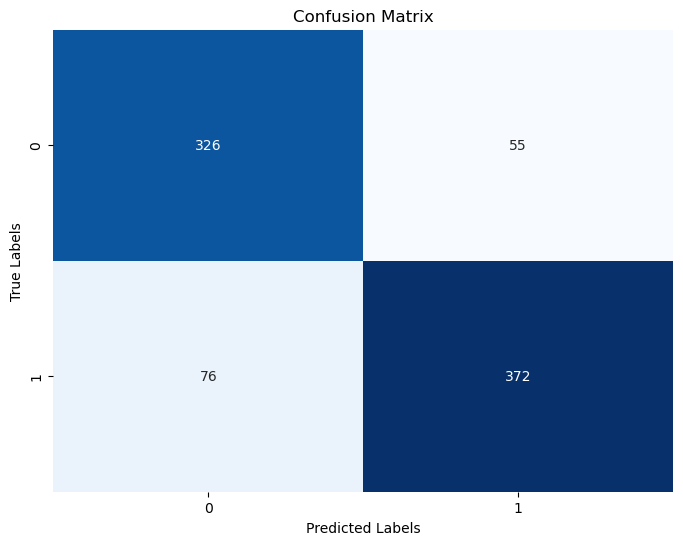

In [17]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()